In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install pytorch-transformers

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pytorch_transformers
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import BertForSequenceClassification, AdamW, WarmupLinearSchedule
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [5]:
#Imports csv file from google drive
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
train_data = pd.read_csv("train_smoteenn_oversample.csv", index_col=0)
validation_data = pd.read_csv("new_merged_scores_validation.csv", index_col=0)
test_data = pd.read_csv("new_merged_scores_test.csv", index_col=0)

In [7]:
def prepare_data(df):
  sentences = df["clean_text"].values
  sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
  labels = df["Euroskepticism_Score"].values
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
  MAX_LEN = 256
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  attention_masks = []
  for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
  return input_ids, attention_masks, labels

In [8]:
train_inputs, train_masks, train_labels = prepare_data(train_data)
validation_inputs, validation_masks, validation_labels = prepare_data(validation_data)
test_inputs, test_masks, test_labels = prepare_data(test_data)

Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors


In [9]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
train_inputs.device

device(type='cpu')

In [10]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [11]:
class EuroskepticClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = BertModel.from_pretrained("bert-base-uncased")
    self.classifier = nn.Linear(768, 2)
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, input_ids, token_type_ids, attention_mask):
    output = self.model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
    output = output[1]
    output = self.dropout(output)
    output = self.classifier(output)
    return output

In [12]:
model = EuroskepticClassifier()
model.cuda()

EuroskepticClassifier(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [13]:
# model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
# model.cuda()

In [14]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [15]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=100, t_total=1000) #0.1 warmup total

In [16]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [17]:
t = [] 
criterion = nn.BCEWithLogitsLoss()

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    w = torch.Tensor([0.13,0.87]).cuda()
    loss = F.cross_entropy(outputs,b_labels,w)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    scheduler.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Train loss: 0.6164521697239999


Epoch:  25%|██▌       | 1/4 [00:58<02:54, 58.17s/it]

Validation Accuracy: 0.8618827160493827
Train loss: 0.30692248476239353


Epoch:  50%|█████     | 2/4 [01:57<01:57, 58.97s/it]

Validation Accuracy: 0.9756944444444444
Train loss: 0.13324138930497262


Epoch:  75%|███████▌  | 3/4 [02:58<00:59, 59.58s/it]

Validation Accuracy: 0.9722222222222222
Train loss: 0.02420870851104458


Epoch: 100%|██████████| 4/4 [03:58<00:00, 59.71s/it]

Validation Accuracy: 0.9756944444444444


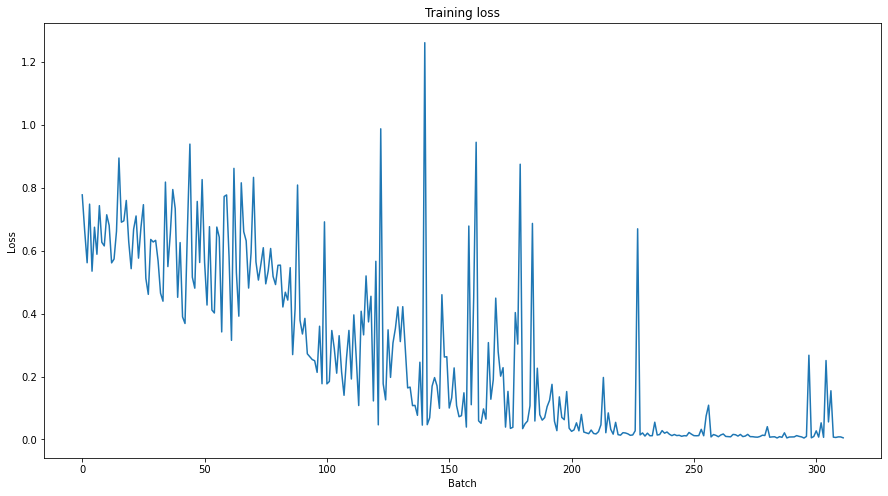

In [18]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [19]:
# Prediction on test set
prediction_inputs = torch.tensor(test_inputs)
prediction_masks = torch.tensor(test_masks)
prediction_labels = torch.tensor(test_labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  for log in logits:
    predictions.append(log)
  for lab in label_ids:
    true_labels.append(lab)

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [21]:
# pred_flat = np.argmax(preds, axis=1).flatten()
preds = np.argmax(predictions, axis=1).flatten()

In [22]:
print(accuracy_score(preds, true_labels))
print(precision_score(preds, true_labels))
print(recall_score(preds, true_labels))
print(f1_score(preds, true_labels))

0.9757834757834758
0.16666666666666666
0.6
0.2608695652173913
